In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2025 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [3]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    './kaggle/input/kul-computer-vision-ga-1-2025/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    './kaggle/input/kul-computer-vision-ga-1-2025/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('./kaggle/input/kul-computer-vision-ga-1-2025/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('./kaggle/input/kul-computer-vision-ga-1-2025/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [4]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [5]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [6]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [7]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [8]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



/var/folders/r9/gttbcddn5yn6mw3sfgy1_7ph0000gn/T/ipykernel_41651/4005177570.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)


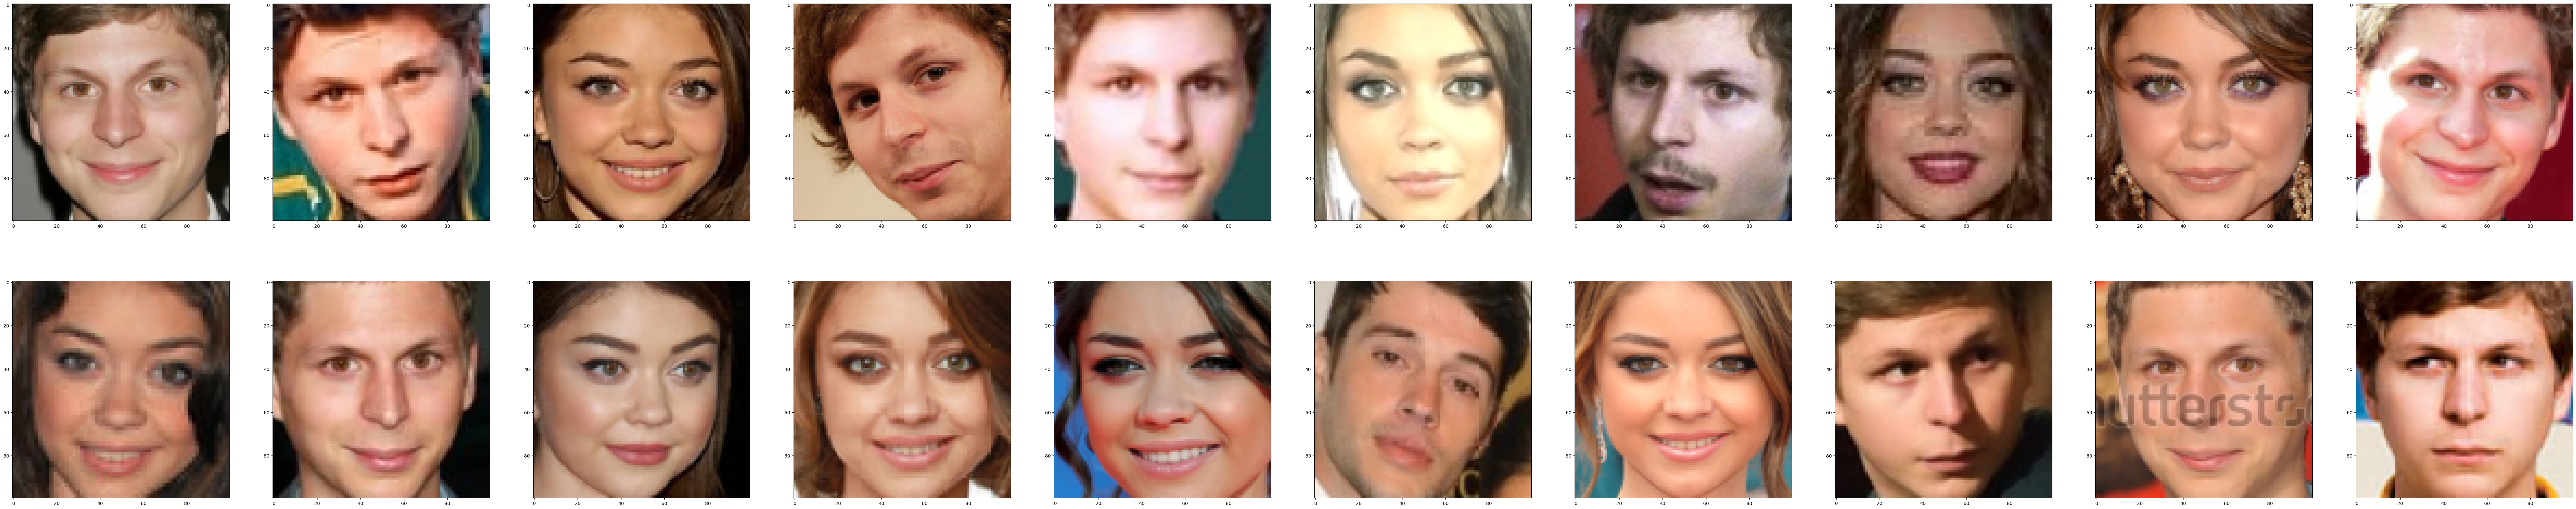

In [9]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

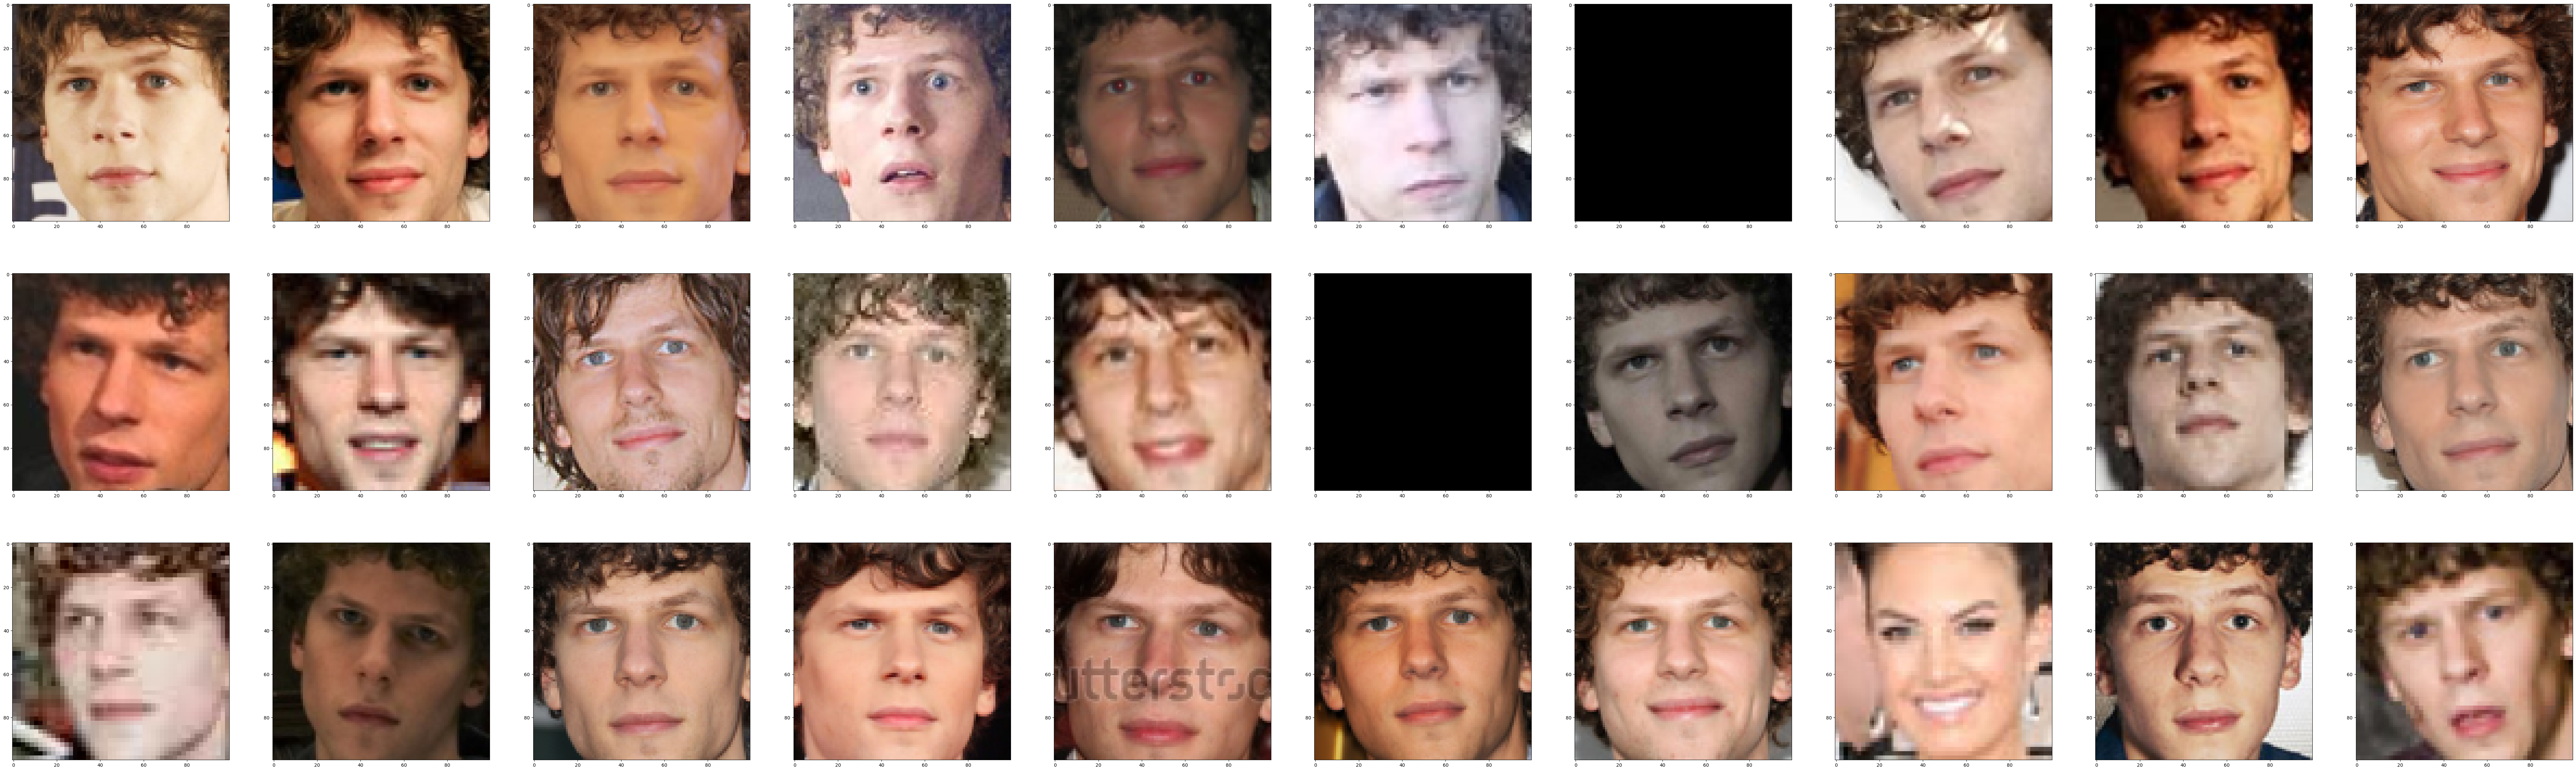

In [10]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

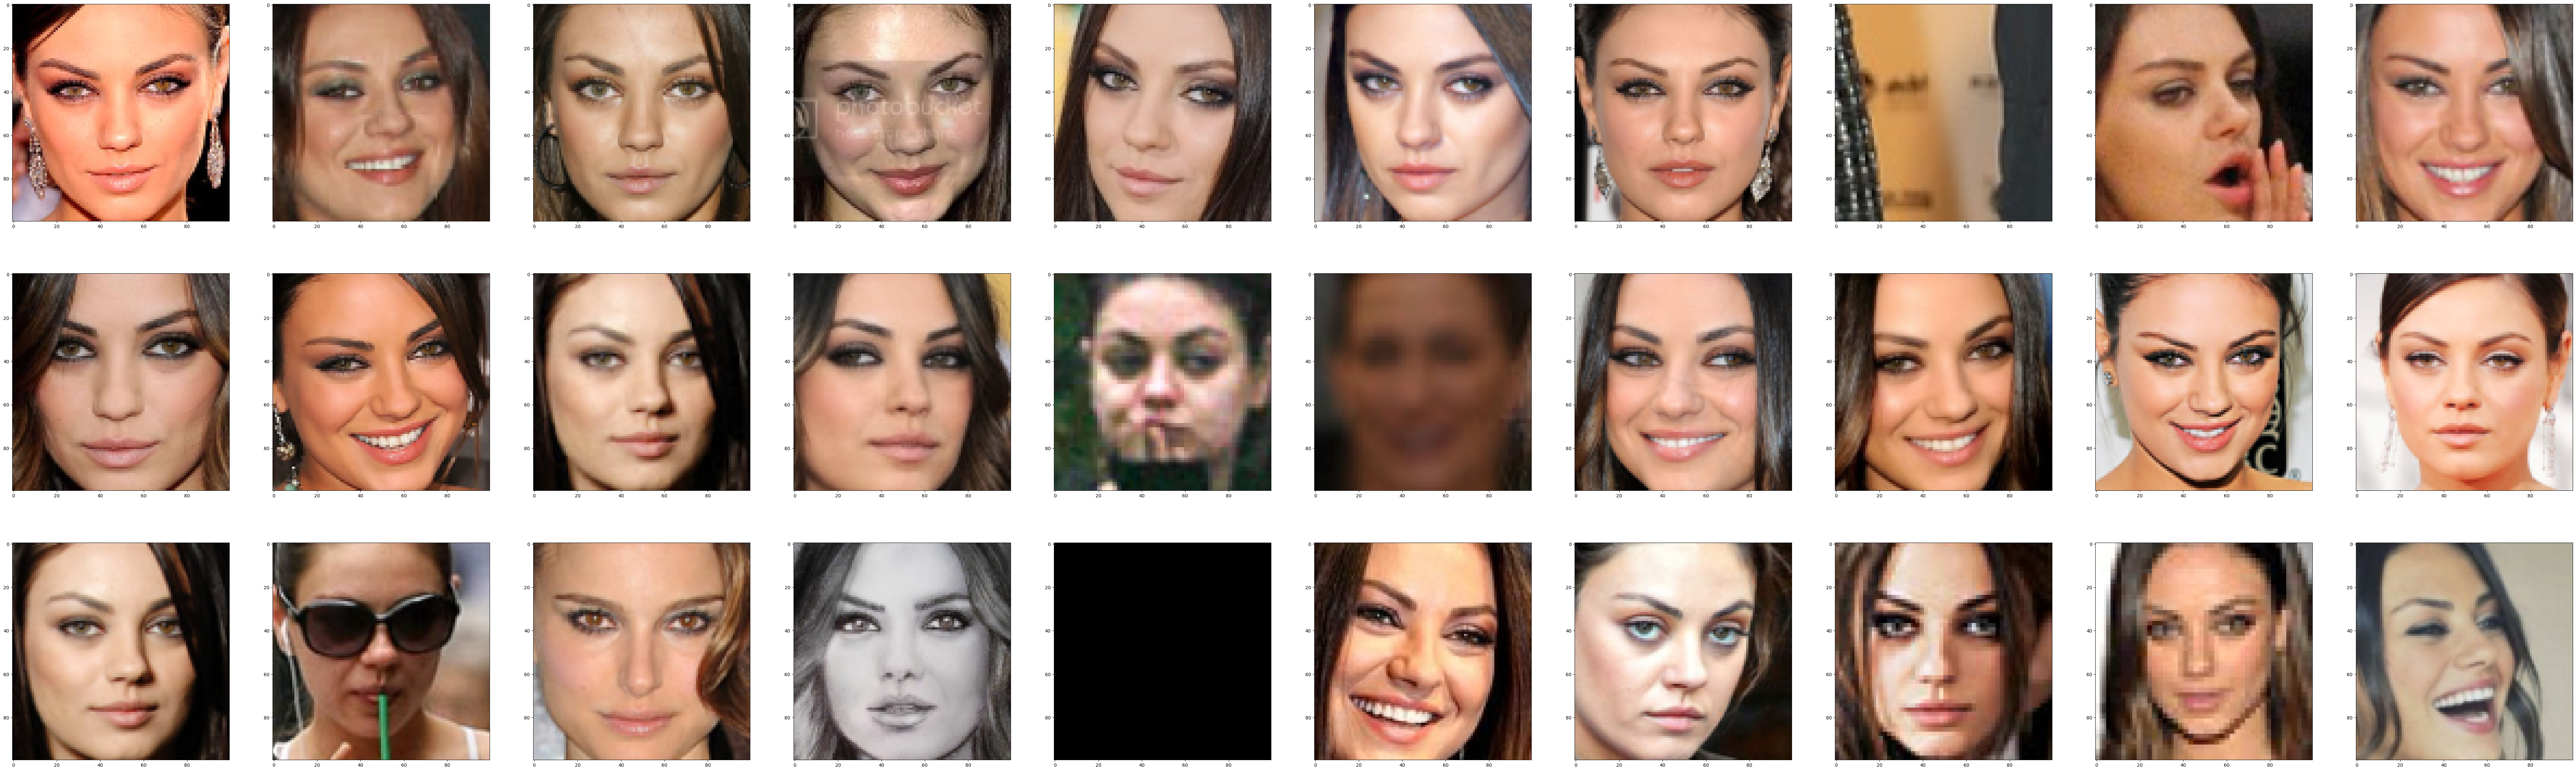

In [11]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [12]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [82]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)


## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [40]:
from skimage.feature import hog

class HOGFeatureExtractor:
    """Extracts Histogram of Oriented Gradients (HOG) features from images."""
    
    def __init__(self, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.orientations = orientations
    
    def transform(self, X):
        features = [hog(img.reshape(100, 100),
                        pixels_per_cell=self.pixels_per_cell,
                        cells_per_block=self.cells_per_block,
                        orientations=self.orientations) for img in X]
        return np.array(features)
    
    def __call__(self, X):
        return self.transform(X)


### 1.1.1. t-SNE Plots
...

In [42]:


from sklearn.manifold import TSNE
import seaborn as sns

import matplotlib.pyplot as plt

# Set random state for reproducibility
np.random.seed(42)

# Extract HOG features from the training data
hog_extractor = HOGFeatureExtractor(pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9)
hog_features = hog_extractor(train_X)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(perplexity=30, random_state=42)
train_tsne = tsne.fit_transform(hog_features)

# Create a DataFrame for easier plotting
df_tsne = pd.DataFrame({
    'X': train_tsne[:, 0], 
    'Y': train_tsne[:, 1], 
    'Class': train_y
})

# Map class labels to names for better visualization
name_mapping = {
    0: 'Michael_Cera',  # Look-alikes
    1: 'Jesse',
    2: 'Mila_Kunis'
}
df_tsne['Name'] = df_tsne['Class'].map(name_mapping)

# Create a nice plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='X', y='Y', hue='Name', data=df_tsne, palette='viridis', s=100)
plt.title('t-SNE Visualization of HOG Features', fontsize=15)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Person', fontsize=10)

# Add some annotations for the clusters
for class_id, name in name_mapping.items():
    subset = df_tsne[df_tsne['Class'] == class_id].iloc[:10]  # Just take a few samples
    plt.annotate(
        f"{name} cluster",
        xy=(subset['X'].mean(), subset['Y'].mean()),
        xytext=(subset['X'].mean() + 1, subset['Y'].mean() + 1),
        arrowprops=dict(arrowstyle='->', lw=1.5),
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
    )

plt.tight_layout()
plt.show()

# Print separation metrics
print("HOG Feature t-SNE Separation Analysis:")
for name in name_mapping.values():
    class_data = df_tsne[df_tsne['Name'] == name]
    print(f"{name} centroid: ({class_data['X'].mean():.2f}, {class_data['Y'].mean():.2f})")
    print(f"{name} spread: {class_data['X'].std() + class_data['Y'].std():.2f}")

ValueError: cannot reshape array of size 30000 into shape (100,100)

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
...

In [119]:
from sklearn.decomposition import PCA

class PCAFeatureExtractor(IdentityFeatureExtractor):
    """Principal Component Analysis (PCA) Feature Extractor."""
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = None
    
    def fit(self, X):
        """Fit PCA on the dataset."""
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)
        return self
    
    def transform(self, X):
        """Transform input data using the trained PCA model."""
        if self.pca is None:
            raise ValueError("PCA model is not fitted yet. Call `fit` first.")
        return self.pca.transform(X)
    
    def inverse_transform(self, X):
        """Reconstruct the original data from the PCA-transformed representation."""
        if self.pca is None:
            raise ValueError("PCA model is not fitted yet. Call `fit` first.")
        return self.pca.inverse_transform(X)
    
    def __call__(self, X):
        return self.transform(X)


### 1.2.1. Eigenface Plots
...

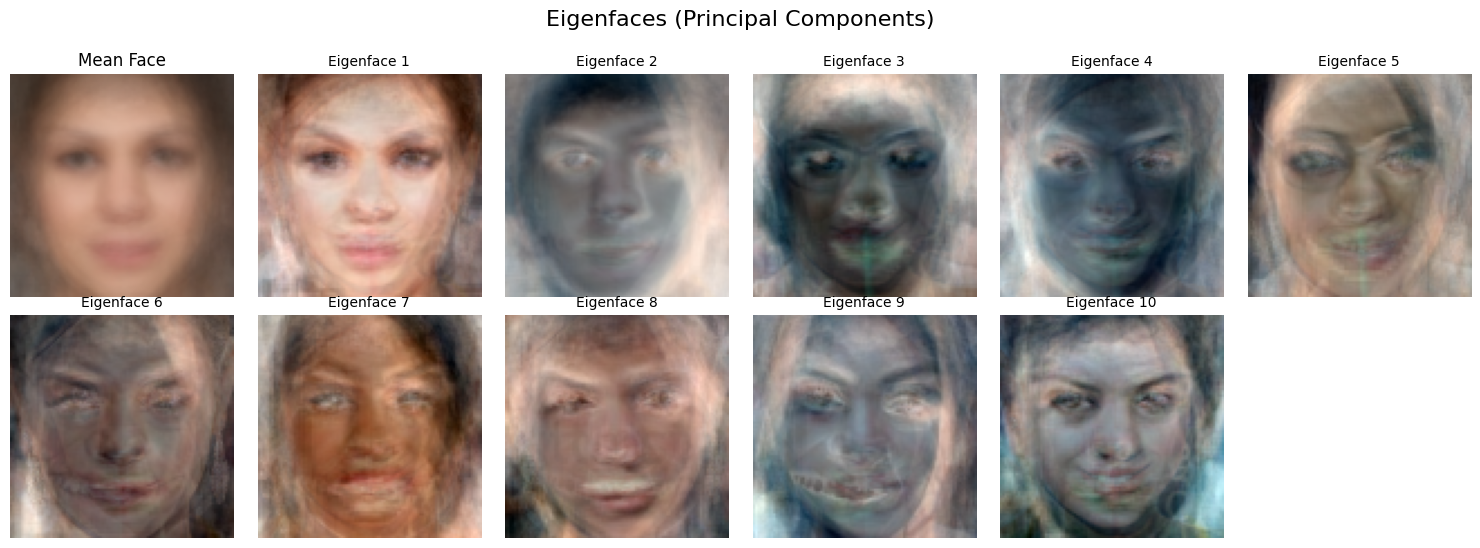

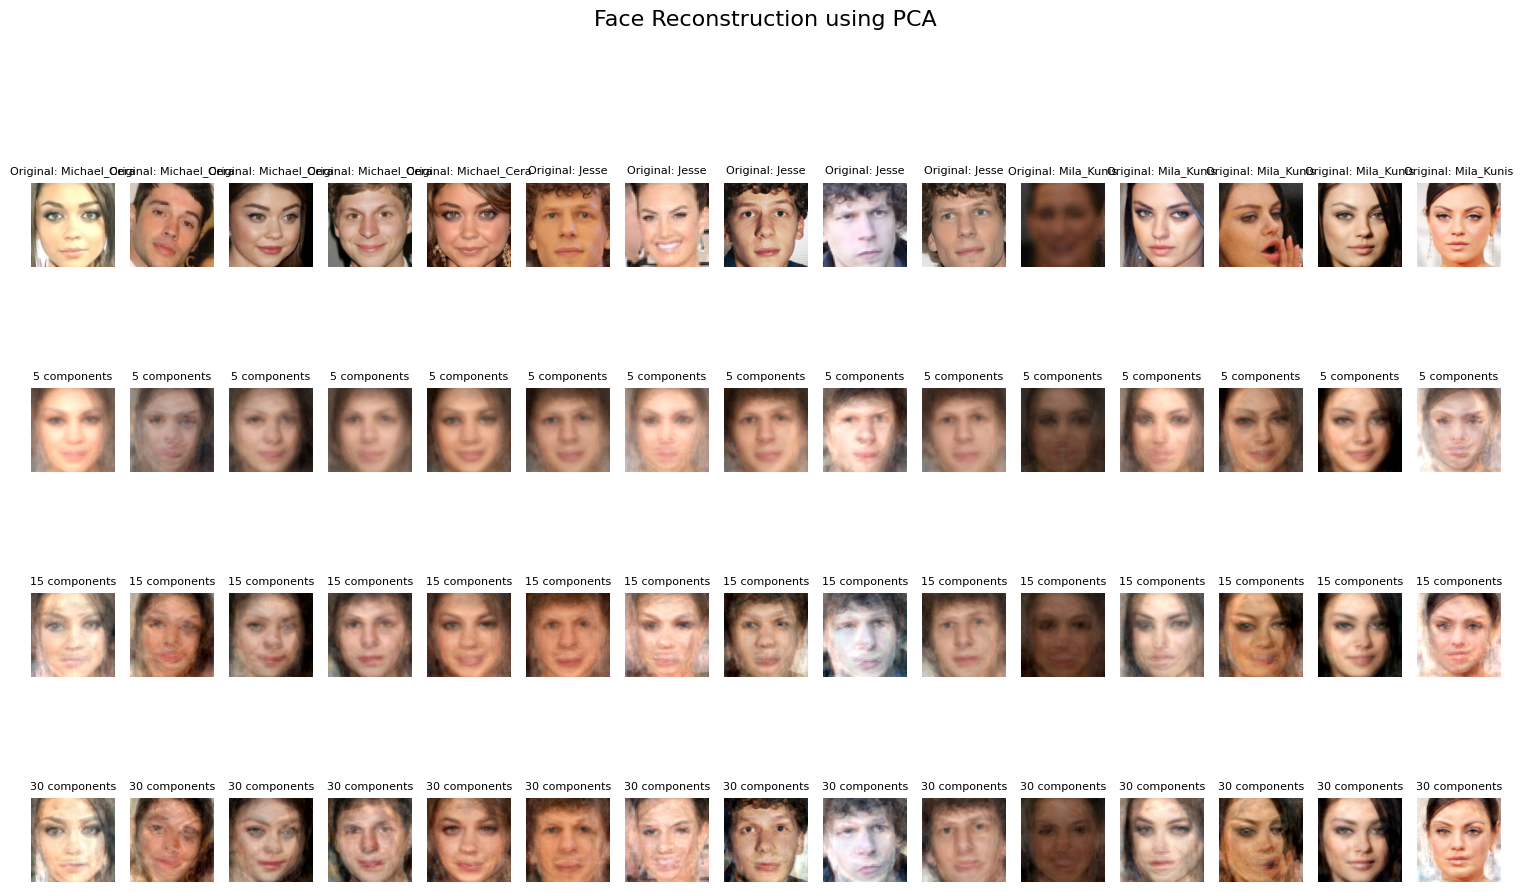

Number of components needed to preserve 90% of variance: 30


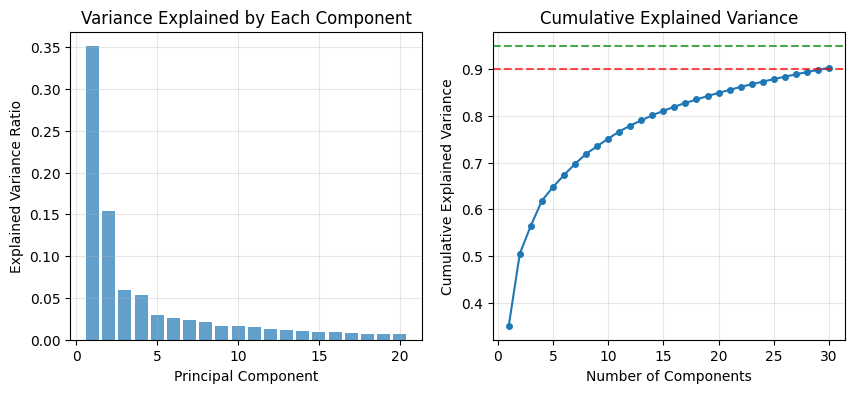

In [139]:
# Create eigenface plots
pca_extractor = PCA(n_components=n_components)
pca_extractor.fit(train_X.reshape(train_X.shape[0], -1))

# Plot the first few eigenfaces (principal components)
plt.figure(figsize=(15, 8))

# Plot the mean face first
mean_face = pca_extractor.mean_.reshape(FACE_SIZE + (3,))
plt.subplot(3, n_components_to_plot//2 + 1, 1)
plt.title("Mean Face", fontsize=12)
plt.imshow(mean_face.astype(np.uint8))
plt.axis('off')

# Plot the eigenfaces
for i in range(n_components_to_plot):
    plt.subplot(3, n_components_to_plot//2 + 1, i + 2)
    # Reshape and normalize the eigenvector for visualization
    eigenface = pca_extractor.components_[i].reshape(FACE_SIZE + (3,))
    eigenface = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
    plt.title(f"Eigenface {i+1}", fontsize=10)
    plt.imshow(eigenface)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Eigenfaces (Principal Components)", fontsize=16, y=0.98)
plt.subplots_adjust(top=0.9)
plt.show()

# Visualize face reconstruction using different numbers of principal components
plt.figure(figsize=(15, 10))

# Select some sample faces from each class
sample_indices = []
for class_id in range(3):
    indices = np.where(train_y == class_id)[0]
    sample_indices.extend(np.random.choice(indices, n_samples, replace=False))

# Original faces row
for i, idx in enumerate(sample_indices):
    plt.subplot(4, len(sample_indices), i+1)
    plt.title(f"Original: {name_mapping[train_y[idx]]}", fontsize=8)
    plt.imshow(train_X[idx])
    plt.axis('off')

# Reconstructions with increasing numbers of components
for row, n_comp in enumerate([5, 15, 30]):
    reduced_pca = PCA(n_components=n_comp)
    reduced_features = reduced_pca.fit_transform(train_X.reshape(train_X.shape[0], -1))
    reconstructed = reduced_pca.inverse_transform(reduced_features)
    
    for i, idx in enumerate(sample_indices):
        plt.subplot(4, len(sample_indices), (row+1)*len(sample_indices) + i+1)
        rec_img = reconstructed[idx].reshape(FACE_SIZE + (3,))
        rec_img = np.clip(rec_img, 0, 255).astype(np.uint8)
        plt.imshow(rec_img)
        plt.title(f"{n_comp} components", fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Face Reconstruction using PCA", fontsize=16, y=0.98)
plt.subplots_adjust(top=0.9)
plt.show()

# Display variance explained
plt.figure(figsize=(10, 4))
explained_var = pca_extractor.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
components = range(1, len(explained_var) + 1)

plt.subplot(1, 2, 1)
plt.bar(components[:20], explained_var[:20], alpha=0.7)
plt.title("Variance Explained by Each Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(components[:50], cumulative_var[:50], 'o-', markersize=4)
plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.7)
plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(alpha=0.3)

print(f"Number of components needed to preserve 90% of variance: {np.where(cumulative_var >= 0.9)[0][0] + 1}")

### 1.2.2. Feature Space Plots
...

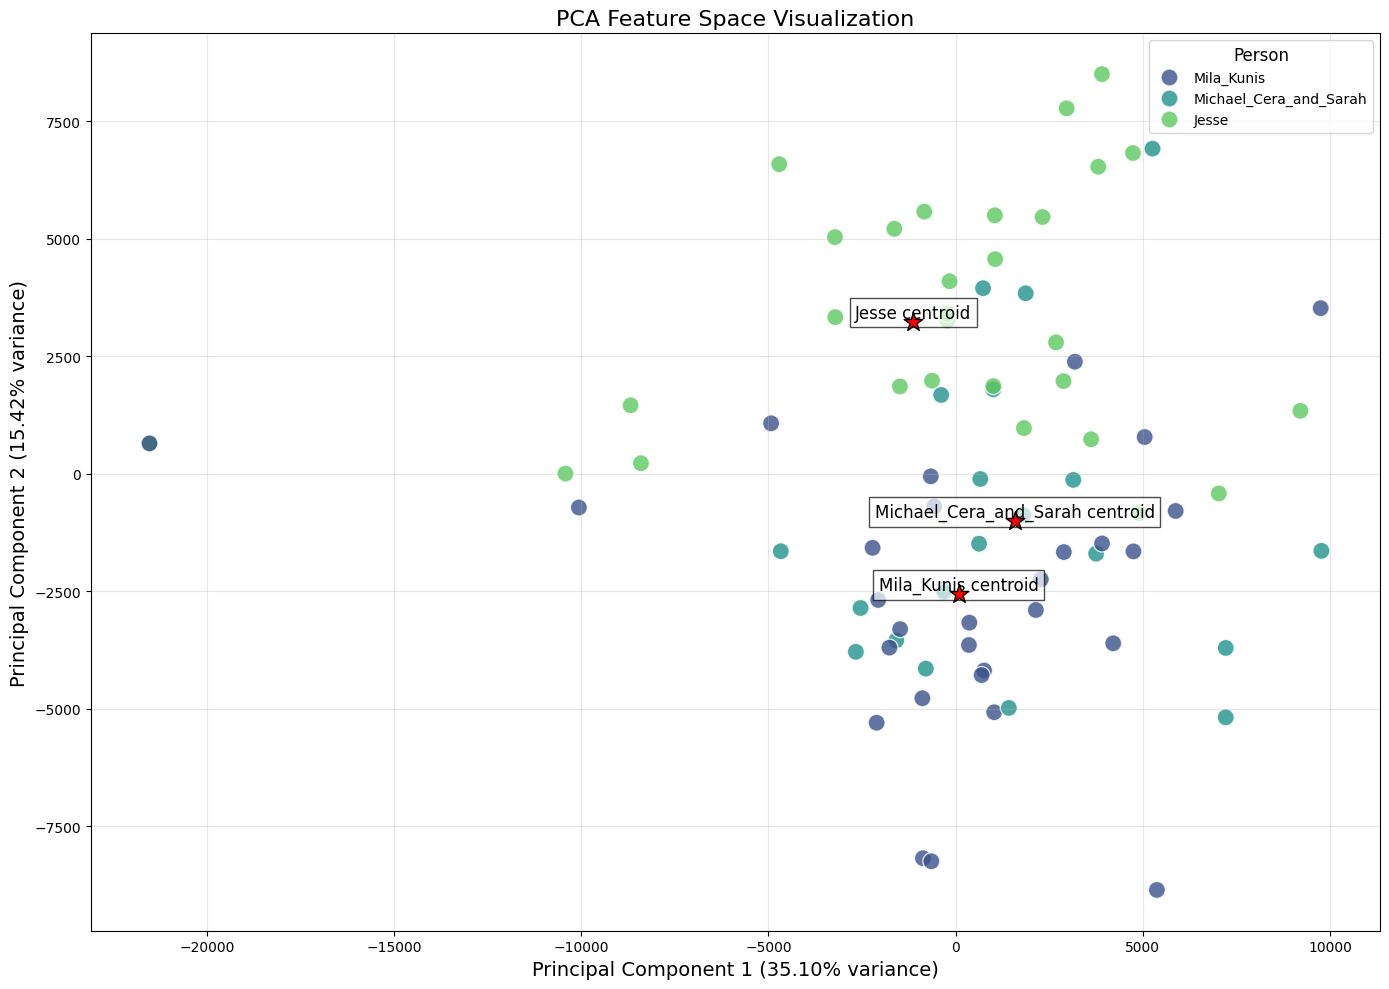

PCA Feature Space Analysis:
Total explained variance in 2D: 50.52%

Mila_Kunis:
  Number of samples: 30
  Centroid: (81.70, -2559.53)
  Spread (std dev): 5510.92, 2927.58
  Distance to Michael_Cera_and_Sarah centroid: 2155.09
  Distance to Jesse centroid: 5915.31

Michael_Cera_and_Sarah:
  Number of samples: 20
  Centroid: (1575.03, -1005.70)
  Spread (std dev): 3636.71, 3237.44
  Distance to Mila_Kunis centroid: 2155.09
  Distance to Jesse centroid: 5026.68

Jesse:
  Number of samples: 30
  Centroid: (-1131.71, 3229.99)
  Spread (std dev): 7075.51, 2603.93
  Distance to Mila_Kunis centroid: 5915.31
  Distance to Michael_Cera_and_Sarah centroid: 5026.68


In [141]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# Prepare data for visualization (flatten images)
train_X_flat = train_X.reshape(train_X.shape[0], -1)

# Apply PCA to reduce to 2 dimensions for visualization
reduced_pca = PCA(n_components=2)
pca_2d = reduced_pca.fit_transform(train_X_flat)

# Create a DataFrame for easier plotting
df_pca = pd.DataFrame({
    'PC1': pca_2d[:, 0],
    'PC2': pca_2d[:, 1],
    'Class': train_y
})

# Map class labels to names for better visualization
name_mapping = {
    0: 'Michael_Cera_and_Sarah',  # Look-alikes
    1: 'Jesse',
    2: 'Mila_Kunis'
}
df_pca['Name'] = df_pca['Class'].map(name_mapping)

# Create a more visually appealing plot
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Name',
    data=df_pca,
    palette='viridis',
    s=150,
    alpha=0.8
)

# Add annotations and styling
plt.title('PCA Feature Space Visualization', fontsize=16)
plt.xlabel(f'Principal Component 1 ({reduced_pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({reduced_pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=14)
plt.legend(title='Person', title_fontsize=12, fontsize=10)

# Improve plot aesthetics
plt.grid(alpha=0.3)
plt.tight_layout()

# Draw confidence ellipses for each class
for class_id, name in name_mapping.items():
    subset = df_pca[df_pca['Class'] == class_id]
    # Calculate centroid
    centroid_x = subset['PC1'].mean()
    centroid_y = subset['PC2'].mean()
    plt.scatter(centroid_x, centroid_y, s=200, marker='*', color='red', edgecolor='black', zorder=10)
    plt.text(centroid_x, centroid_y, f"{name} centroid", fontsize=12, 
             ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

plt.show()

# Print some metrics about class separation
print("PCA Feature Space Analysis:")
total_var = reduced_pca.explained_variance_ratio_.sum()
print(f"Total explained variance in 2D: {total_var:.2%}")

# Calculate between-class and within-class distances
for class_name in df_pca['Name'].unique():
    class_data = df_pca[df_pca['Name'] == class_name]
    print(f"\n{class_name}:")
    print(f"  Number of samples: {len(class_data)}")
    print(f"  Centroid: ({class_data['PC1'].mean():.2f}, {class_data['PC2'].mean():.2f})")
    print(f"  Spread (std dev): {class_data['PC1'].std():.2f}, {class_data['PC2'].std():.2f}")
    
    # Calculate distances to other classes
    for other_class in df_pca['Name'].unique():
        if other_class != class_name:
            other_data = df_pca[df_pca['Name'] == other_class]
            # Distance between centroids
            dist = ((class_data['PC1'].mean() - other_data['PC1'].mean())**2 + 
                    (class_data['PC2'].mean() - other_data['PC2'].mean())**2)**0.5
            print(f"  Distance to {other_class} centroid: {dist:.2f}")

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [19]:
from sklearn.metrics import accuracy_score, f1_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [93]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [129]:
from sklearn.svm import SVC

class SVMClassificationModel:
    """Support Vector Machine classifier with customizable kernel."""
    
    def __init__(self, kernel='linear', C=1.0, gamma='scale'):
        """Initialize SVM classifier with specified parameters.
        
        Parameters
        ----------
        kernel : str, default='linear'
            Specifies the kernel type to be used in the algorithm.
            Options: 'linear', 'poly', 'rbf', 'sigmoid'.
        C : float, default=1.0
            Regularization parameter. The strength of the regularization is 
            inversely proportional to C.
        gamma : {'scale', 'auto'} or float, default='scale'
            Kernel coefficient for 'rbf', 'poly' and 'sigmoid' kernels.
        """
        self.model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True)
    
    def fit(self, X, y):
        """Train the model using the training data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like of shape (n_samples,)
            Target vector relative to X.

        Returns
        -------
        self : object
            Returns self.
        """
        self.model.fit(X, y)
        return self
        
    def predict(self, X):
        """Predict class labels for samples in X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Samples.
            
        Returns
        -------
        y_pred : array-like of shape (n_samples,)
            Class labels for samples in X.
        """
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Return probability estimates for samples in X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Samples.
            
        Returns
        -------
        y_proba : array-like of shape (n_samples, n_classes)
            The class probabilities for each sample.
        """
        return self.model.predict_proba(X)
    
    def __call__(self, X):
        return self.predict(X)

class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    
    def fit(self, X, y):
        raise NotImplmentedError
        
    def predict(self, X):
        raise NotImplmentedError

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [130]:
feature_extractor = PCAFeatureExtractor(n_components=10)
train_X_reshaped = train_X.reshape(train_X.shape[0], -1)  # Flatten all but first dimension
feature_extractor.fit(train_X_reshaped)

classifier = SVMClassificationModel()
classifier.fit(feature_extractor(train_X_reshaped), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [131]:
# evaluate performance of the model on the training set
train_y_star = model(train_X_reshaped)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

'The performance on the training set is 0.94. This however, does not tell us much about the actual performance (generalisability).'

In [136]:
# predict the labels for the test set 
test_X_reshaped = test_X.reshape(test_X.shape[0], -1)
test_y_star = model(test_X_reshaped)

print("The predictions for the test set are:")
test_y_star


The predictions for the test set are:


array([1, 0, 0, ..., 1, 0, 0])

# 5. Publishing best results

In [137]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         0
2         0
3         1
4         1
...     ...
1811      1
1812      2
1813      1
1814      0
1815      0

[1816 rows x 1 columns]

In [26]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
